# Specifying your own neural network with MNEflow

In [1]:
# Here we use the same dataset as in the basic mneflow example
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.chdir("C:\\Users\\ipzub\\projs\\mneflow")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow


fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

<Info | 26 non-empty fields
    acq_pars : str | 12870 items
    acq_stim : str | 45 items
    bads : list | 0 items
    ch_names : list | MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, ...
    chs : list | 204 items (GRAD: 204)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 27 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 21 items (3 Cardinal, 4 HPI, 14 Extra)
    events : list | 1 items
    experimenter : str | 8 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 172.17630004882812 Hz
    meas_date : tuple | 2011-04-26 11:33:18 GMT
    meas_id : dict | 4 items
    nchan : int | 204
    proc_history : list | 0 items
    proj_id : ndarray | 1 items
    proj_name : str | 4 items
    projs : list | grad_ssp_upright.fif : PCA-v1: on, ...
    sfreq : float | 600.614990234375 Hz
    subject_info : dict | 9 items

In [2]:
#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=False,
                  segment=False,
                  test_set='holdout')


##since meta file already exists and overwrite=False produce_tfrecords does not need to repeat the preprocessing
meta = mneflow.produce_tfrecords(epochs,**import_opt)  
#del epochs

Metadata file found, restoring


In [4]:
#let's make a simple peceptron-like classifier using all channels*timepoints as features with keras
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.constraints import max_norm

class MyNetwork(mneflow.models.BaseModel):
    #In the simplest case all you need to do is to override the computational graph with your own
    def build_graph(self):
        self.scope = 'custom_model'
        flat = Flatten()(self.inputs)
        self.fc = Dense(units=8, activation="softmax")
        y_pred = self.fc(flat)
        return y_pred
    
    #the same can be done with Optimizer._set_optimizer method if you need to use a custom optimization pipeline  

In [7]:
graph_specs = dict(model_path=import_opt['savepath'])
dataset = mneflow.Dataset(meta, train_batch=100)
model = MyNetwork(dataset, graph_specs)
model.build()
model.train(n_epochs=10, eval_step=100, early_stopping=3)

Input shape: (1, 361, 204)
y_pred: (None, 8)
Initialization complete!
Epoch 1/10
100/100 - 9s - loss: 1.4411 - cat_ACC: 0.8290 - val_loss: 1.6348 - val_cat_ACC: 0.6270
Epoch 2/10
100/100 - 9s - loss: 1.3098 - cat_ACC: 0.9636 - val_loss: 1.6877 - val_cat_ACC: 0.5952
Epoch 3/10
100/100 - 9s - loss: 1.2995 - cat_ACC: 0.9741 - val_loss: 1.6722 - val_cat_ACC: 0.5952
Epoch 4/10
100/100 - 9s - loss: 1.2928 - cat_ACC: 0.9809 - val_loss: 1.6682 - val_cat_ACC: 0.6032
1/1 [==============================] - 0s 2ms/step - loss: 1.6348 - cat_ACC: 0.6270
Training complete: loss: 1.634806513786316, Metric: 0.6269841194152832
1/1 [==============================] - 0s 2ms/step - loss: 1.6669 - cat_ACC: 0.6026
Updating log: test loss: 1.6669 test metric: 0.6026


### Since our custom model inherits some methods from the parent class we can e.g. plot the training history easily

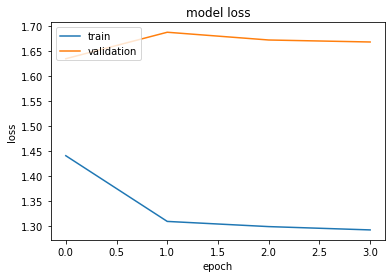

In [8]:
model.plot_hist()

